# AI Lyrics Generator in Taylor Swift Style
This notebook builds a GPT-2-like decoder-only transformer to generate Taylor Swift-style lyrics.

# Part 0: Setup & Installation

In [1]:
!pip install transformers kagglehub -q

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from transformers import GPT2Tokenizer
import kagglehub
from tqdm import tqdm
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


# Part 1: Data Preparation with Structure

In [3]:
# Download dataset
path = kagglehub.dataset_download("PromptCloudHQ/taylor-swift-song-lyrics-from-all-the-albums")
print("Path to dataset files:", path)

100%|██████████| 68.7k/68.7k [00:00<00:00, 343kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/PromptCloudHQ/taylor-swift-song-lyrics-from-all-the-albums/versions/1


In [4]:
# Load and structure the data
file_path = f"{path}/taylor_swift_lyrics.csv"
data = pd.read_csv(file_path, encoding='ISO-8859-1')

print(f"Total lines: {len(data)}")
print(f"Unique songs: {data['track_title'].nunique()}")
print(f"Unique albums: {data['album'].nunique()}")
print("\nSample data:")
print(data.head())

Total lines: 4862
Unique songs: 94
Unique albums: 6

Sample data:
         artist         album track_title  track_n  \
0  Taylor Swift  Taylor Swift  Tim McGraw        1   
1  Taylor Swift  Taylor Swift  Tim McGraw        1   
2  Taylor Swift  Taylor Swift  Tim McGraw        1   
3  Taylor Swift  Taylor Swift  Tim McGraw        1   
4  Taylor Swift  Taylor Swift  Tim McGraw        1   

                                         lyric  line  year  
0          He said the way my blue eyes shined     1  2006  
1  Put those Georgia stars to shame that night     2  2006  
2                       I said, "That's a lie"     3  2006  
3                  Just a boy in a Chevy truck     4  2006  
4         That had a tendency of gettin' stuck     5  2006  


In [5]:
# Create structured dataset with metadata
songs = []
for (track_title, album), group in data.groupby(['track_title', 'album']):
    # Get song metadata
    year = group['year'].iloc[0]
    lyrics = '\n'.join(group['lyric'].tolist())

    # Format with special tokens and metadata
    formatted_song = f"<|startoftext|>\n<ALBUM>{album}</ALBUM>\n<YEAR>{year}</YEAR>\n<TITLE>{track_title}</TITLE>\n\n{lyrics}\n<|endoftext|>"
    songs.append(formatted_song)

# Combine all songs
all_lyrics = '\n\n'.join(songs)

print(f"Total songs: {len(songs)}")
print(f"Total characters: {len(all_lyrics):,}")
print("\n" + "="*80)
print("Sample formatted song:")
print("="*80)
print(songs[0][:500])

Total songs: 94
Total characters: 183,386

Sample formatted song:
<|startoftext|>
<ALBUM>reputation</ALBUM>
<YEAR>2017</YEAR>
<TITLE>...Ready for It?</TITLE>

Knew he was a killer first time that I saw him
Wondered how many girls he had loved and left haunted
But if he's a ghost, then I can be a phantom
Holdin' him for ransom, some
Some boys are tryin' too hard, he don't try at all though
Younger than my exes, but he act like such a man, so
I see nothing better, I keep him forever
Like a vendetta-ta
I, I, I see how this is gon' go
Touch me and you'll never be 


# Part 2: Tokenization with BPE (Subword)

In [6]:
# Initialize GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Add special tokens for our use case
special_tokens = {
    'additional_special_tokens': [
        '<|startoftext|>', '<|endoftext|>',
        '<ALBUM>', '</ALBUM>',
        '<YEAR>', '</YEAR>',
        '<TITLE>', '</TITLE>'
    ]
}
tokenizer.add_special_tokens(special_tokens)
tokenizer.pad_token = tokenizer.eos_token

vocab_size = len(tokenizer)
print(f"Vocabulary size: {vocab_size:,}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Vocabulary size: 50,264


In [7]:
# Tokenize the entire dataset
encoded_lyrics = tokenizer.encode(all_lyrics)
print(f"Total tokens: {len(encoded_lyrics):,}")

# Create train/validation split (90/10)
n = int(0.9 * len(encoded_lyrics))
train_data = torch.tensor(encoded_lyrics[:n], dtype=torch.long)
val_data = torch.tensor(encoded_lyrics[n:], dtype=torch.long)

print(f"Train tokens: {len(train_data):,}")
print(f"Val tokens: {len(val_data):,}")

Token indices sequence length is longer than the specified maximum sequence length for this model (49332 > 1024). Running this sequence through the model will result in indexing errors


Total tokens: 49,332
Train tokens: 44,398
Val tokens: 4,934


# Part 3: Model Architecture (Enhanced GPT-2)

In [8]:
# Hyperparameters - Significantly improved
batch_size = 32          # Reduced for memory efficiency
block_size = 256         # Context window
n_embd = 256            # Embedding dimension
n_head = 4              # Attention heads
n_layer = 4             # Transformer layers
dropout = 0.3           # Dropout rate
learning_rate = 1e-4    # Learning rate
max_iters = 1000       # Training iterations
eval_interval = 50     # Evaluation frequency
eval_iters = 20        # Iterations for loss estimation

print(f"Model Configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Block size: {block_size}")
print(f"  Embedding dim: {n_embd}")
print(f"  Attention heads: {n_head}")
print(f"  Layers: {n_layer}")
print(f"  Dropout: {dropout}")

Model Configuration:
  Batch size: 32
  Block size: 256
  Embedding dim: 256
  Attention heads: 4
  Layers: 4
  Dropout: 0.3


In [9]:
# Data loading functions
def get_batch(split):
    """Generate a batch of data"""
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    """Estimate loss on train and val sets"""
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

@torch.no_grad()
def calculate_perplexity():
    """Calculate perplexity on validation set"""
    losses = estimate_loss()
    val_loss = losses['val']
    perplexity = torch.exp(torch.tensor(val_loss))
    return perplexity.item()

In [10]:
class Head(nn.Module):
    """Single head of self-attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        # Compute attention scores with scaling
        scale = C ** -0.5
        wei = q @ k.transpose(-2, -1) * scale
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        # Weighted aggregation
        out = wei @ v
        return out


class MultiHeadAttention(nn.Module):
    """Multi-head self-attention"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedForward(nn.Module):
    """Position-wise feed-forward network"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),  # GELU instead of ReLU (GPT-2 standard)
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # Pre-normalization (GPT-2 style)
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class GPTLanguageModel(nn.Module):
    """GPT-2 style language model"""

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """Initialize weights with GPT-2 initialization"""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # Token and position embeddings
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb

        # Transformer blocks
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        # Calculate loss if targets provided
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None, block_special_tokens=True):
      self.eval()

      # Get special token IDs to block
      if block_special_tokens:
          special_token_ids = [
              tokenizer.encode('<ALBUM>')[0],
              tokenizer.encode('</ALBUM>')[0],
              tokenizer.encode('<YEAR>')[0],
              tokenizer.encode('</YEAR>')[0],
              tokenizer.encode('<TITLE>')[0],
              tokenizer.encode('</TITLE>')[0],
          ]

      for _ in range(max_new_tokens):
          idx_cond = idx[:, -block_size:]
          logits, _ = self(idx_cond)
          logits = logits[:, -1, :] / temperature

          # Block special tokens after initial prompt (ADD THIS)
          if block_special_tokens and idx.size(1) > 20:  # After metadata section
              for token_id in special_token_ids:
                  logits[:, token_id] = -float('Inf')

          if top_k is not None:
              v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
              logits[logits < v[:, [-1]]] = -float('Inf')

          probs = F.softmax(logits, dim=-1)
          idx_next = torch.multinomial(probs, num_samples=1)
          idx = torch.cat((idx, idx_next), dim=1)

      self.train()
      return idx

In [11]:
# Initialize model
model = GPTLanguageModel()
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params/1e6:.2f}M")
print(f"Trainable parameters: {trainable_params/1e6:.2f}M")

Total parameters: 29.01M
Trainable parameters: 29.01M


# Part 4: Training with Advanced Optimization

In [12]:
# Optimizer with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    betas=(0.9, 0.95),
    weight_decay=0.2
)

# Learning rate scheduler (cosine annealing)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=max_iters,
    eta_min=1e-5
)

print("Optimizer and scheduler initialized!")

Optimizer and scheduler initialized!


In [13]:
# Training loop with improvements
print("Starting training...\n")

# Early stopping
best_val_loss = float('inf')
patience = 5
patience_counter = 0
improvement_threshold = 0.01

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'perplexity': [],
    'learning_rate': []
}

for iter in range(max_iters):

    # Evaluation
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        perplexity = calculate_perplexity()
        current_lr = optimizer.param_groups[0]['lr']

        # Store history
        history['train_loss'].append(losses['train'].item())
        history['val_loss'].append(losses['val'].item())
        history['perplexity'].append(perplexity)
        history['learning_rate'].append(current_lr)

        print(f"Step {iter:5d} | Train Loss: {losses['train']:.4f} | "
              f"Val Loss: {losses['val']:.4f} | Perplexity: {perplexity:.2f} | "
              f"LR: {current_lr:.2e}")

        # Early stopping check
        if losses['val'] < best_val_loss - improvement_threshold:
            best_val_loss = losses['val']
            patience_counter = 0
            # Save best model
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'config': {                           # ADD THIS
                    'vocab_size': vocab_size,
                    'block_size': block_size,
                    'n_embd': n_embd,
                    'n_head': n_head,
                    'n_layer': n_layer,
                    'dropout': dropout,
                },
                'iter': iter,
                'val_loss': best_val_loss,
                'perplexity': perplexity,
                'tokenizer_name': 'gpt2'
            }, 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping triggered at iteration {iter}")
                break

    # Training step
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step()

print("\nTraining complete!")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training...



/tmp/ipython-input-1657192381.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perplexity = torch.exp(torch.tensor(val_loss))


Step     0 | Train Loss: 10.8295 | Val Loss: 10.8370 | Perplexity: 50837.06 | LR: 1.00e-04
Step    50 | Train Loss: 8.3050 | Val Loss: 8.5031 | Perplexity: 4956.95 | LR: 9.94e-05
Step   100 | Train Loss: 6.6156 | Val Loss: 6.9985 | Perplexity: 1088.99 | LR: 9.78e-05
Step   150 | Train Loss: 5.6130 | Val Loss: 6.1937 | Perplexity: 497.35 | LR: 9.51e-05
Step   200 | Train Loss: 5.0741 | Val Loss: 5.8594 | Perplexity: 358.55 | LR: 9.14e-05
Step   250 | Train Loss: 4.6615 | Val Loss: 5.6786 | Perplexity: 297.48 | LR: 8.68e-05
Step   300 | Train Loss: 4.3800 | Val Loss: 5.5836 | Perplexity: 272.14 | LR: 8.15e-05
Step   350 | Train Loss: 4.1223 | Val Loss: 5.5357 | Perplexity: 250.43 | LR: 7.54e-05
Step   400 | Train Loss: 3.9814 | Val Loss: 5.5281 | Perplexity: 247.18 | LR: 6.89e-05
Step   450 | Train Loss: 3.8322 | Val Loss: 5.4634 | Perplexity: 239.81 | LR: 6.20e-05
Step   500 | Train Loss: 3.6967 | Val Loss: 5.4729 | Perplexity: 255.09 | LR: 5.50e-05
Step   550 | Train Loss: 3.6204 | Val

In [14]:
# Load best model
checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from iteration {checkpoint['iter']}")
print(f"Validation loss: {checkpoint['val_loss']:.4f}")
print(f"Perplexity: {checkpoint['perplexity']:.2f}")

Loaded best model from iteration 450
Validation loss: 5.4634
Perplexity: 239.81


# Part 5: Text Generation with Advanced Sampling

In [15]:
def generate_lyrics(prompt, max_length=500, temperature=0.8, top_k=40):
    """
    Generate Taylor Swift style lyrics

    Args:
        prompt: Starting text (can include metadata)
        max_length: Maximum tokens to generate
        temperature: Sampling temperature (0.7-1.0 recommended)
        top_k: Top-k sampling parameter (20-50 recommended)
    """
    model.eval()

    # Encode prompt
    context = torch.tensor(
        tokenizer.encode(prompt),
        dtype=torch.long,
        device=device
    ).unsqueeze(0)

    # Generate
    with torch.no_grad():
        generated = model.generate(
            context,
            max_new_tokens=max_length,
            temperature=temperature,
            top_k=top_k
        )

    # Decode
    output = tokenizer.decode(generated[0].tolist())

    # Clean up output (stop at end token)
    if '<|endoftext|>' in output:
        output = output[:output.index('<|endoftext|>')]

    return output

## Example 1: Generate with Metadata

In [16]:
prompt1 = """<|startoftext|>
<ALBUM>1989</ALBUM>
<YEAR>2014</YEAR>
<TITLE>New Song</TITLE>

"""

lyrics1 = generate_lyrics(prompt1, max_length=300, temperature=0.8, top_k=40)
print("Generated Lyrics (with metadata):")
print("="*80)
print(lyrics1)
print("="*80)

Generated Lyrics (with metadata):
<|startoftext|>
<ALBUM>1989</ALBUM>
<YEAR>2014</YEAR>
<TITLE>New Song</TITLE>

<|startoftext|>





I'm there's the best in the best of your one of the one of here, that
I'm the rain on the phone, I think we're, I've been
But I could be
But I'm-oh-oh, I'm the woods yet?
You don't have when you want you are a one of the best of the rain
I know it's all the way you've been back, this is a love me
This is
But I say
And I had to the time
Stay, I never see you
And you're the woods yet?
We have me
I could take it's like a girl (I know I'd be there, oh- I don't do
And I've got me I'm not like a smile
And you're just just out of the time, I know it's the time
You know you like a girl, I loved you're all the day
But if you'm not is the place
Just a girl my life
But I'll be the last time
I don't it's the very me
Oh, I have to meet you've been for the best of your face
Like we're like a just the best of my face
I know what you
So it's like a girl ( back to tell y

## Example 2: Continue from a Starting Line

In [17]:
prompt2 = """<|startoftext|>
<ALBUM>Red</ALBUM>
<YEAR>2012</YEAR>
<TITLE>Autumn Love</TITLE>

The leaves are falling all around
"""

lyrics2 = generate_lyrics(prompt2, max_length=300, temperature=0.9, top_k=50)
print("Generated Lyrics (continuing from prompt):")
print("="*80)
print(lyrics2)
print("="*80)

Generated Lyrics (continuing from prompt):
<|startoftext|>
<ALBUM>Red</ALBUM>
<YEAR>2012</YEAR>
<TITLE>Autumn Love</TITLE>

The leaves are falling all around
It's like a name
Look what it
But I see, and you were and your face
Don't like you're the you're so you're good here's not the other to tell you got you think
And I ever said
We keepCause I said you don't never come back to a bad like I'll be (
And a girl I'm just see and I'll be me
Why out of your to know
Oh, I was in the best
And the you
(Yeah, oh
And I said I'll be the last you can't look all the bad
You could don't know you would?
I get the place with you say "But I'd never take a girl
And I think I said,'re not a best game
And I'll was the clear yet?
But you're here, oh
I know you're the in this night with you'll do you like a whole water, I'm gonna be I know all the water?
And you got the last you're like you, come back of me not is not the way to tell you
I like you're, play it?
You say, play it's all the name, they'd got a

## Example 3: Experiment with Different Temperatures

In [18]:
base_prompt = """<|startoftext|>
<ALBUM>Lover</ALBUM>
<YEAR>2019</YEAR>
<TITLE>Midnight Thoughts</TITLE>

"""

temperatures = [0.5, 0.8, 1.0]

for temp in temperatures:
    print(f"\n{'='*80}")
    print(f"Temperature: {temp} (lower = more conservative, higher = more creative)")
    print(f"{'='*80}")
    lyrics = generate_lyrics(base_prompt, max_length=200, temperature=temp, top_k=40)
    print(lyrics)
    print()


Temperature: 0.5 (lower = more conservative, higher = more creative)
<|startoftext|>
<ALBUM>Lover</ALBUM>
<YEAR>2019</YEAR>
<TITLE>Midnight Thoughts</TITLE>

<|startoftext|>





So I'll be the best of the way you're the time

I'm in the time
That's the woods yet?
And all I know that we're not the ground
And I'm not the best of the clear yet?
I'm the way
I don't know is the way
We're all the time
I'm not so is the way you
And I'm not a bad
And I'm not the time
I'm not the time
I'm just are the way you in the woods yet?
I don't be the whole way you're the world
I'm not the last time I'm not the time
And I was the woods yet?
And I'm just want to know what you're the clear yet?
And I can't know you're a little
I've been a girl
And I'm not the first time I'm not like a girl
And I'm not


Temperature: 0.8 (lower = more conservative, higher = more creative)
<|startoftext|>
<ALBUM>Lover</ALBUM>
<YEAR>2019</YEAR>
<TITLE>Midnight Thoughts</TITLE>

<|startoftext|>




I could don't
'Cause I'll 

# Part 6: Model Analysis & Visualization

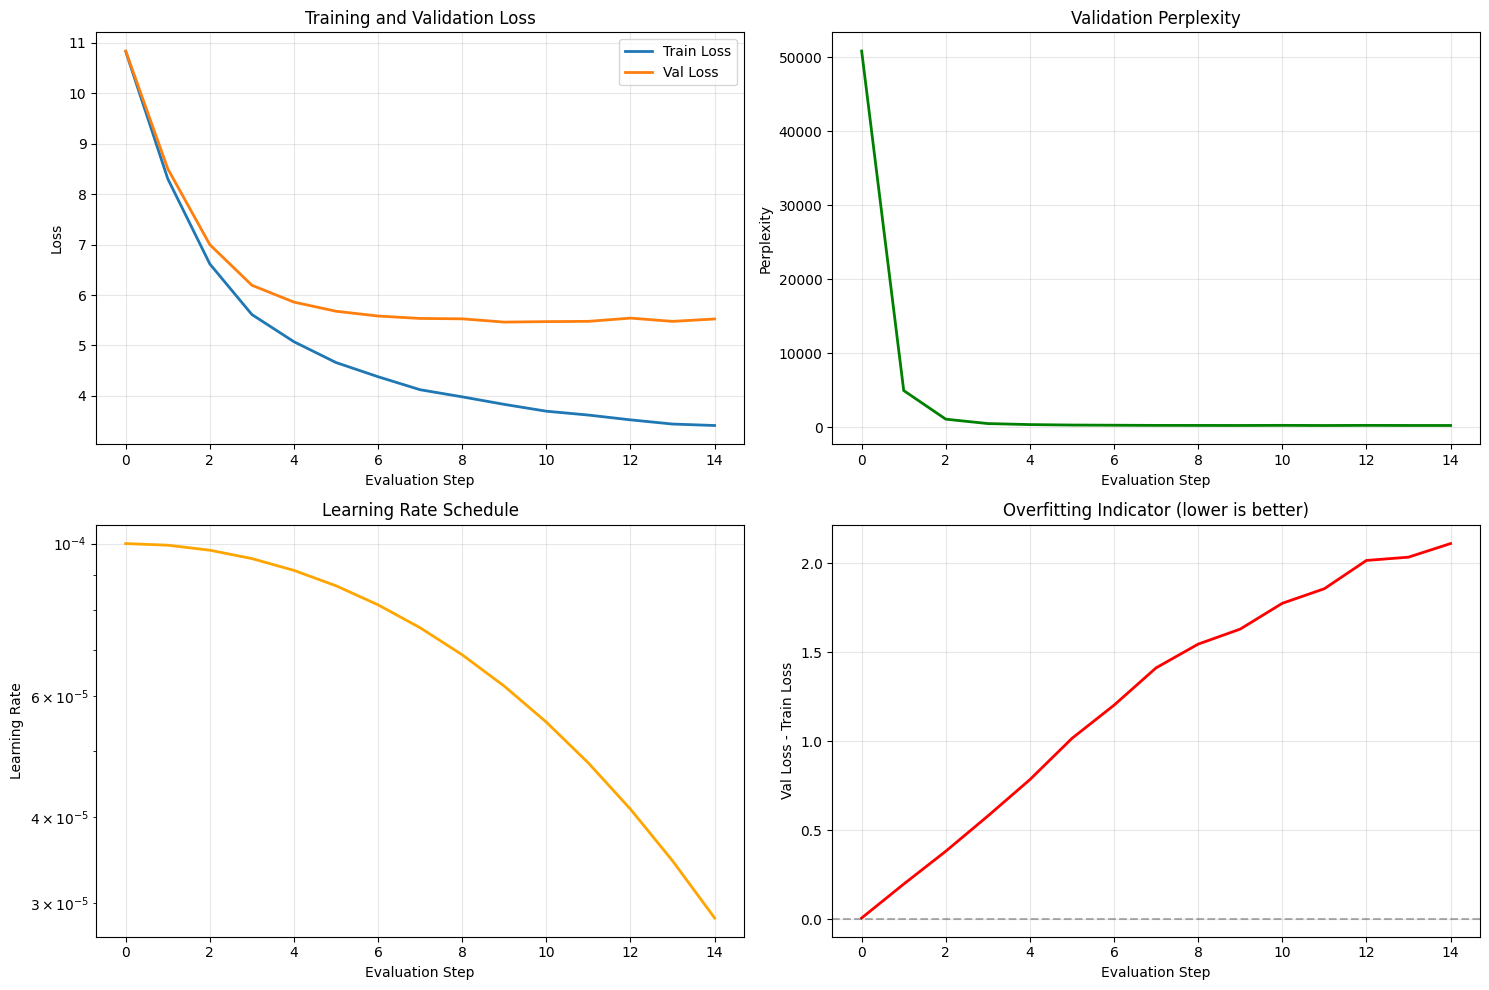

Final metrics:
  Train Loss: 3.4134
  Val Loss: 5.5253
  Perplexity: 238.28
  Overfitting gap: 2.1119


In [19]:
import matplotlib.pyplot as plt

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training and validation loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Evaluation Step')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Perplexity
axes[0, 1].plot(history['perplexity'], color='green', linewidth=2)
axes[0, 1].set_xlabel('Evaluation Step')
axes[0, 1].set_ylabel('Perplexity')
axes[0, 1].set_title('Validation Perplexity')
axes[0, 1].grid(True, alpha=0.3)

# Learning rate
axes[1, 0].plot(history['learning_rate'], color='orange', linewidth=2)
axes[1, 0].set_xlabel('Evaluation Step')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Loss difference (overfitting indicator)
loss_diff = [v - t for v, t in zip(history['val_loss'], history['train_loss'])]
axes[1, 1].plot(loss_diff, color='red', linewidth=2)
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1, 1].set_xlabel('Evaluation Step')
axes[1, 1].set_ylabel('Val Loss - Train Loss')
axes[1, 1].set_title('Overfitting Indicator (lower is better)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Final metrics:")
print(f"  Train Loss: {history['train_loss'][-1]:.4f}")
print(f"  Val Loss: {history['val_loss'][-1]:.4f}")
print(f"  Perplexity: {history['perplexity'][-1]:.2f}")
print(f"  Overfitting gap: {loss_diff[-1]:.4f}")

# Part 7: Download Model for Future Use

In [20]:
from google.colab import files
files.download('best_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>